# First make sure all the files are ready for analysis

In [ ]:
import sys
sys.path.append('/home/itskov/workspace/lab/DeepSemantic/WormSegmentation')

import matplotlib
#matplotlib.use('TkAgg')

from glob2 import glob
from Behavior.General.ExpDir import ExpDir
from Behavior.General.Experiment import Experiment
from os import listdir, path
import pandas as pd


# Debug (Temporary)
from Behavior.General import Track
sys.modules['Track'] = Track
# Debug (Temporary)

import numpy as np
import re

print('Starting..')

# Here is where the tracked files are stored.
rootDir = '/home/itskov/Temp/behav/28-Nov-2019/'
#rootDir = '/mnt/storageNASRe/ChristianData/ChrisNewTracks/'
allTrackedFiles = glob(rootDir + '/**/*tracks.npy')
allTrackedDirectories = [path.dirname(tracksFile) for tracksFile in allTrackedFiles]


# Here we store our experiments meta information
expDf = pd.DataFrame(columns=['date','time', 'cond','fullFile'])

for i, trackedDir in enumerate(allTrackedDirectories):
    fullFile = path.join(rootDir, trackedDir)
    print("%d. Going over %s" % (i, fullFile))
    
    # This object helps us manage the tracked files.
    expDir = ExpDir(str(fullFile))
    
    #if True:
    if (expDir.getExpFile() == None) or (not expDir.isValid()):
        #newExp = Experiment(expDir.getVidFile(), np.load(expDir.getTracksFile()))
        newExp = Experiment(expDir)
        newExp.takeScale()
        newExp.addCirclePotisionRad('startReg',newExp._scale / 5)
        newExp.addCirclePotisionRad('endReg',newExp._scale / 4)
        newExp.save()
        pass
        
        
    currentDate = re.search('\d\d-\w\w\w-\d\d\d\d',trackedDir)[0]
    currentTime = re.search('_(\d\d\.\d\d\.\d\d)',path.basename(fullFile))[1]
    cond = re.search('(.*)\.avi',path.basename(fullFile))[1]
    
    # Irregularities
    #if cond == 'STAP_Mock':
    #    cond = 'MOCK_STAP'
    #elif cond == 'LTAV_MOCK':
    #    cond = 'MOCK_LTAV'
    #elif cond == 'TEMP_EYAL_LIGHT':
    #    continue
    
    expDf.loc[i] = [currentDate, currentTime, cond, fullFile]
    #print('Date: ' + currentDate + ' Cond: ' + cond)
expDf


# Pair analyses

In [7]:
import sys
sys.path.append('/home/itskov/workspace/lab/DeepSemantic/WormSegmentation')


import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual, widgets, VBox,HBox

from Behavior.Visualizers.PairwiseAnalyses import PairWiseRoi
from Behavior.Visualizers.PairwiseAnalyses import PairWiseProjectionDensity, PairWiseOccupVisoulatizer, PairWiseSpeedDensity, PairWiseRevDistances
from Behavior.General.TracksFilter import filterTracksForAnalyses



# First experiment widgets
#print(pd.unique(expDf['date']))
dateWidget1 = widgets.Dropdown(options=pd.unique(expDf['date']),value=expDf['date'][0], description='Date')
condWidget1 = widgets.Dropdown(options=pd.unique(expDf['cond']),value=expDf['cond'][0], description='Cond')
timeWidget1 = widgets.Dropdown(options=[], description='Time')

# Second experiment widgets
dateWidget2 = widgets.Dropdown(options=pd.unique(expDf['date']),value=expDf['date'][0], description='Date')
condWidget2 = widgets.Dropdown(options=pd.unique(expDf['cond']),value=expDf['cond'][0], description='Cond')
timeWidget2 = widgets.Dropdown(options=[], description='Time')

out = widgets.Output()
display(out)

@out.capture()
def runAnalysis(arg):
    firstCond = condWidget1.value
    firstDate = dateWidget1.value
    firstTime = timeWidget1.value
    secondCond = condWidget2.value
    secondDate = dateWidget2.value
    secondTime = timeWidget2.value
    
    firstFile = expDf[(expDf.cond == firstCond) & 
                      (expDf.date == firstDate) & 
                      (expDf.time == firstTime)]['fullFile']
    
    secondFile = expDf[(expDf.cond == secondCond) & 
                       (expDf.date == secondDate) & 
                       (expDf.time == secondTime)]['fullFile']
    
    firstFile = path.join(firstFile.values[0],'exp.npy')
    secondFile = path.join(secondFile.values[0],'exp.npy')
    
    print(firstFile)
    print(secondFile)
    firstExp = np.load(firstFile)[0]
    secondExp = np.load(secondFile)[0]
        
    print('Filtering tracks for anaylses..')
    #firstExp._tracks = filterTracksForAnalyses(firstExp._tracks)
    #secondExp._tracks = filterTracksForAnalyses(secondExp._tracks)

    PairWiseRoi(firstCond, firstExp, secondCond, secondExp)
    PairWiseProjectionDensity(firstCond, firstExp, secondCond, secondExp)
    PairWiseSpeedDensity(firstCond, firstExp, secondCond, secondExp)
    PairWiseOccupVisoulatizer(firstCond, firstExp, secondCond, secondExp)
    PairWiseRevDistances(firstCond, firstExp, secondCond, secondExp)
    

# Run button
runButton = widgets.Button(description="Run")
runButton.on_click(runAnalysis)

def on_cond_value_change1(*change):        
    dateWidget1.options = pd.unique(expDf[expDf['cond'] == condWidget1.value]['date'])
    timeWidget1.options = pd.unique(expDf[expDf['cond'] == condWidget1.value]['time'])
    
def on_date_value_change1(*change):
    timeWidget1.options = expDf[(expDf['cond'] == condWidget1.value) & (expDf['date'] == dateWidget1.value) ]['time']
    
def on_cond_value_change2(*change):        
    dateWidget2.options = pd.unique(expDf[expDf['cond'] == condWidget2.value]['date'])
    timeWidget2.options = pd.unique(expDf[expDf['cond'] == condWidget2.value]['time'])

def on_date_value_change2(*change):
    timeWidget2.options = expDf[(expDf['cond'] == condWidget2.value) & (expDf['date'] == dateWidget2.value) ]['time']

condWidget1.observe(on_cond_value_change1, names='value')
dateWidget1.observe(on_date_value_change1, names='value')
condWidget2.observe(on_cond_value_change2, names='value')
dateWidget2.observe(on_date_value_change2, names='value')

# Display layout
HBox([VBox([condWidget1, dateWidget1, timeWidget1]), VBox([condWidget2, dateWidget2, timeWidget2]), runButton])

Output()

# Create Pair Movie


Reinitializing.
Reinitializing.
Allocating space.
Filtering tracks. Before 33574, After: 20079
Allocating space.
Filtering tracks. Before 59252, After: 35507
Processed Frame 4498 / 4500

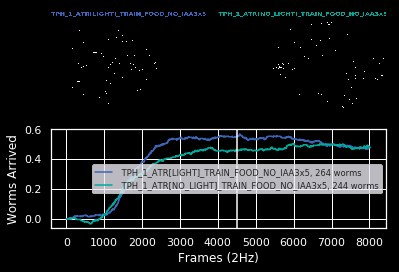

In [3]:
import sys
sys.path.append('/home/itskov/workspace/lab/DeepSemantic/WormSegmentation')


from Behavior.General.ExpPair import ExpPair

expPair = ExpPair('/home/itskov/Temp/behav/28-Nov-2019/TPH_1_ATR[LIGHT]_TRAIN_FOOD_NO_IAA3x5.avi_19.49.59/exp.npy', 
                  '/home/itskov/Temp/behav/28-Nov-2019/TPH_1_ATR[NO_LIGHT]_TRAIN_FOOD_NO_IAA3x5.avi_19.49.15/exp.npy')

expPair.createPairVisualization(4500, dpi=250)